----
format: 
    html: 
        embed-resources: true
---

import statements

In [22]:
from itertools import product
from datetime import datetime
from typing import Union
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset


from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

scheduler

In [23]:
class CosineWarmupScheduler(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

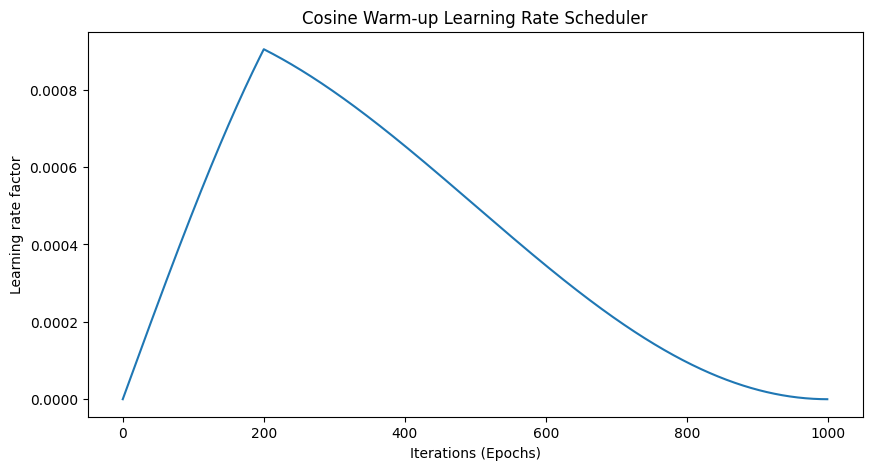

In [24]:
def plot_scheduler(base, epochs, warm_up):
    p = nn.Parameter(torch.empty(4,4))
    optimizer = torch.optim.AdamW([p], lr=base)
    lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=warm_up, max_iters=epochs)
    lr = [base*lr_scheduler.get_lr_factor(e) for e in range(epochs)]

    # Plotting
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(list(range(epochs)), lr)
    ax.set_ylabel("Learning rate factor")
    ax.set_xlabel("Iterations (Epochs)")
    ax.set_title("Cosine Warm-up Learning Rate Scheduler")
    plt.show()

base = 0.001
epochs = 1000
warm_up = 200
plot_scheduler(base, epochs, warm_up)

import data

In [25]:
religion_data = pd.read_csv('../data/religion_data_no99.csv')

transformer

In [26]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, ff_dim, num_heads, dropout, norm_eps, device):
        super().__init__()
        self.device = device

        # Multi-head self-attention
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim, eps=norm_eps)
        self.norm2 = nn.LayerNorm(embed_dim, eps=norm_eps)

        # Feedforward network
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention with residual connection
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))

        # Feedforward with residual connection
        ff_output = self.feedforward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x




class TransformerClassifier(nn.Module):
    def __init__(
        self, input_dim, embed_dim, ff_dim, num_heads,
        num_blocks, num_classes, dropout, norm_eps, device
    ):
        super().__init__()

        self.device = device

        # Project numerical features to embedding space
        self.input_proj = nn.Linear(input_dim, embed_dim)

        # Stacked transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim,
                ff_dim=ff_dim,
                num_heads=num_heads,
                dropout=dropout,
                norm_eps=norm_eps,
                device=device
            ) for _ in range(num_blocks)
        ])

        # Final classification layer
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x: (batch_size, input_dim)
        x = self.input_proj(x)                  # (batch_size, embed_dim)
        x = x.unsqueeze(1)                      # (batch_size, 1, embed_dim)

        for block in self.blocks:
            x = block(x)                        # (batch_size, 1, embed_dim)

        x = x.squeeze(1)                        # (batch_size, embed_dim)
        logits = self.classifier(x)             # (batch_size, num_classes)
        return logits



hyperparams

In [27]:
# Model hyper-parameters
NUM_BLOCKS = 2     # Number of transformer bocks
NUM_HEADS = 4      # Number of heads in each multi-attention layer
EMB_DIM = 512      # Embedding (num_heads*key_dim)
FF_DIM = 1028       # Max dimension of feed forward layer (other dim in emb.)
LAYER_EPS = 1e-6   # Added to denominator of layer norm for numerical stability

# Data hyper-parameters
EPOCHS = 100       # Total epochs
BATCH_SIZE = 128   # Number of sequences (true batch = sequence length X batch)
START_BATCH = 0    # Which batch number to start from

# Training and optimization hyper-parameters
LR = 0.001
DROPOUT = 0.1      # Dropout rate
WARM_UP = 30       # LR warm up iterations (epoch before 0.001 reached)
MAX_ITER = 2000    # Max iterations of the LR scheduler
BETA_1 = 0.9       # Optimizer hyper-parameter (decay rate of momentum)
BETA_2 = 0.999     # Optimizer hyper-parameter (decay rate of squared gradients)
EPS = 1e-7         # Optimizer hyper-parameter Prevents division by 0

model_number = 0
load_model = False
checkpoint_path = Path(
    './checkpoints/checkpoint-{}.pt'.format(model_number)
    )

assert EMB_DIM%NUM_HEADS == 0, 'Embedding dimension must be divisible by number of attention heads'

# Check devices
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

dataloader

In [28]:
df_clean = religion_data.drop(columns=['CURREL'])

X = df_clean.drop(columns=['RELTRAD'])  
y = df_clean['RELTRAD']               
X = X.values if hasattr(X, 'values') else X
y = y.values if hasattr(y, 'values') else y

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

y_train = y_train / 10000
y_val = y_val /  10000
y_test = y_test / 10000


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [ ]:
# Data preparation
input_dim = X_train.shape[1]  # Number of features (columns)
num_classes = len(set(y_train))  # Number of unique classes

# Instantiate the model
model = TransformerClassifier(
    input_dim=input_dim,     # Number of features
    embed_dim=EMB_DIM,       # Embedding dimension
    ff_dim=FF_DIM,           # Feedforward layer dimension
    num_heads=NUM_HEADS,     # Number of attention heads
    num_blocks=NUM_BLOCKS,   # Number of transformer blocks
    num_classes=num_classes, # Number of classes
    dropout=DROPOUT,         # Dropout rate
    norm_eps=LAYER_EPS,      # Layer norm epsilon for numerical stability
    device=torch.device(device)  # Use either CPU or GPU
)

# Move model to the appropriate device (CPU or GPU)
model = model.to(device)

# Check the model
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = CosineWarmupScheduler(optimizer, warmup=WARM_UP, max_iters=MAX_ITER)



TransformerClassifier(
  (input_proj): Linear(in_features=99, out_features=512, bias=True)
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (feedforward): Sequential(
        (0): Linear(in_features=512, out_features=1028, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=1028, out_features=512, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (classifier): Linear(in_features=512, out_features=12, bias=True)
)


In [30]:
from IPython import display

def plot_training(
        train_loss, train_acc, val_loss, val_acc
        ):
    fig = plt.figure(1, figsize=(24, 6))
    plt.clf()

    ax1 = fig.add_subplot(1, 4, 1) # (Rows, Columns, Position)
    ax2 = fig.add_subplot(1, 4, 2) # (Rows, Columns, Position)
    ax3 = fig.add_subplot(1, 4, 3) # (Rows, Columns, Position)
    ax4 = fig.add_subplot(1, 4, 4) # (Rows, Columns, Position)
    epochs = range(len(train_loss))

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (Categorical Cross Entropy)')
    ax1.plot(epochs, train_loss, marker='o', linestyle=':')

    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(epochs, train_acc, marker='o', linestyle=':')

    ax3.set_title('Validation Loss')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.plot(epochs, val_loss, marker='o', color='g', linestyle=':')

    ax4.set_title('Validation Accuracy')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.plot(epochs, val_acc, marker='o', color='C3', linestyle=':')

    display.display(plt.gcf())
    display.clear_output(wait=True)

train

Epoch [22/100], Batch [100/545], Loss: 0.8048
Epoch [22/100], Batch [200/545], Loss: 0.4604
Epoch [22/100], Batch [300/545], Loss: 0.9173
Epoch [22/100], Batch [400/545], Loss: 0.9045
Epoch [22/100], Batch [500/545], Loss: 0.7795
Epoch [22/100] Loss: 0.7811, Accuracy: 0.7275
Validation Loss: 0.8270, Validation Accuracy: 0.7192
No improvement in validation loss for 5 epoch(s).
Early stopping triggered after 5 epochs without improvement.
Loaded best model based on validation loss.


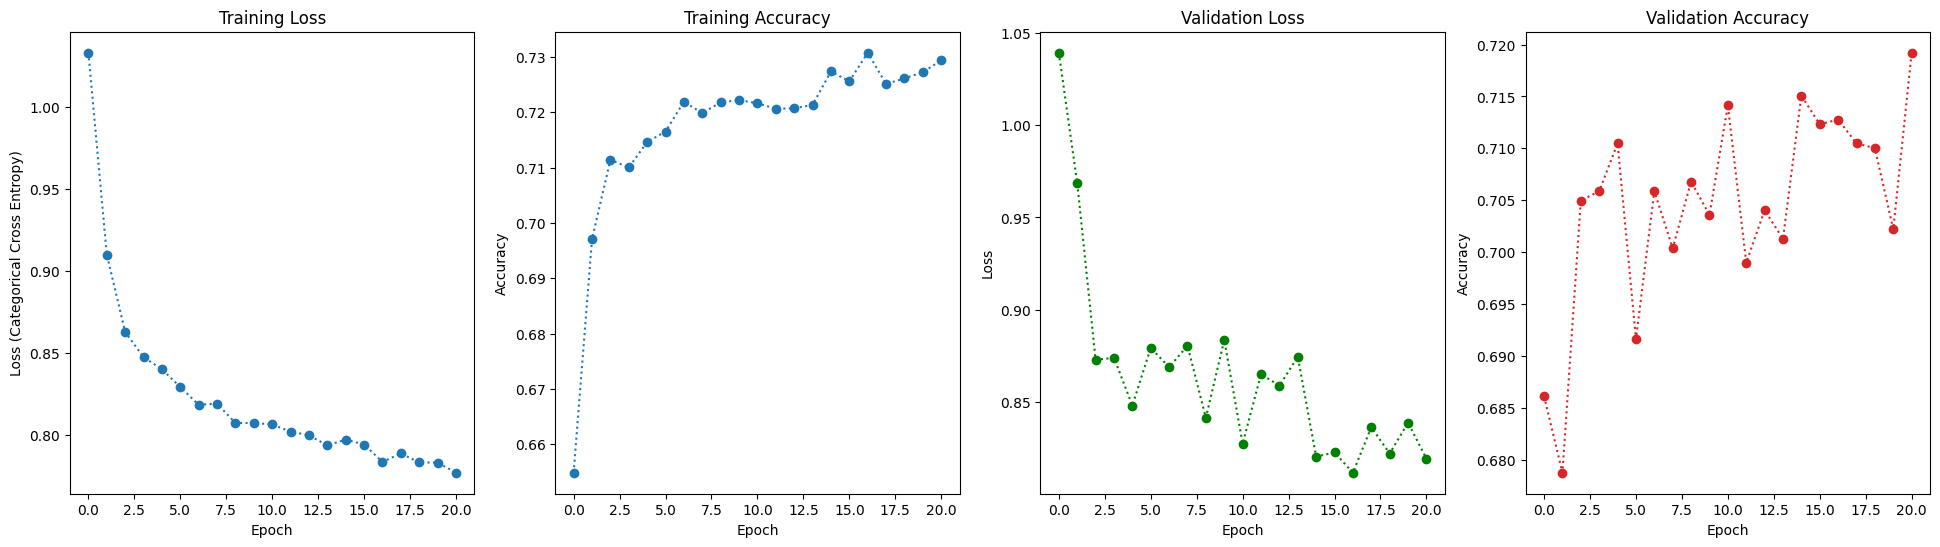

In [31]:
import copy

def training(model): 
    # Initialize tracking lists
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []

    # Early stopping parameters
    patience = 5
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None

    # Set model to training mode
    model.train()

    # Initialize optimizer and loss function
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=LR,
        betas=(BETA_1, BETA_2),
        eps=EPS
    )
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(EPOCHS):
        running_loss = 0.0
        correct = 0
        total = 0

        model.train()
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

            if batch_idx % 100 == 99:
                print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Calculate average epoch loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        train_loss.append(epoch_loss)
        train_acc.append(epoch_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                outputs = model(X_val_batch)
                loss = criterion(outputs, y_val_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == y_val_batch).sum().item()
                val_total += y_val_batch.size(0)

        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total

        valid_loss.append(val_loss)
        valid_acc.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_without_improvement += 1
            print(f"No improvement in validation loss for {epochs_without_improvement} epoch(s).")

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

        # Plot training progress
        plot_training(train_loss, train_acc, valid_loss, valid_acc)

    # Restore best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model based on validation loss.")
    
    return model, best_val_loss

model,best_val_loss = training(model)


Test Loss: 0.7795, Test Accuracy: 0.7414


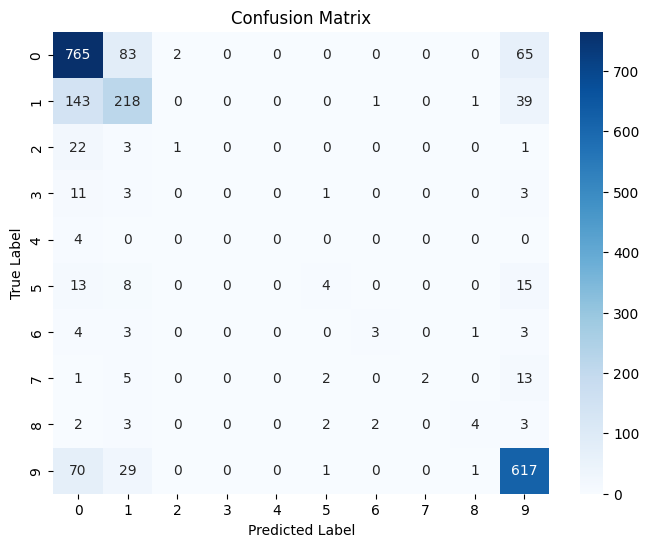

In [32]:
# Set model to evaluation mode
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

all_preds = []
all_labels = []

# No need to track gradients during inference
with torch.no_grad():  
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        outputs = model(X_test_batch)
        
        loss = criterion(outputs, y_test_batch)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())  # Store predictions on CPU
        all_labels.extend(y_test_batch.cpu().numpy())  # Store true labels on CPU
        
        test_correct += (predicted == y_test_batch).sum().item()
        test_total += y_test_batch.size(0)

# Calculate average test loss and accuracy
test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


hyperparam tuning

Epoch [26/100], Batch [100/545], Loss: 0.9415
Epoch [26/100], Batch [200/545], Loss: 0.6261
Epoch [26/100], Batch [300/545], Loss: 0.6625
Epoch [26/100], Batch [400/545], Loss: 0.9520
Epoch [26/100], Batch [500/545], Loss: 0.8023
Epoch [26/100] Loss: 0.7311, Accuracy: 0.7355
Validation Loss: 0.7585, Validation Accuracy: 0.7284
No improvement in validation loss for 5 epoch(s).
Early stopping triggered after 5 epochs without improvement.
Loaded best model based on validation loss.

✅ Best config: {'EMB_DIM': 128, 'FF_DIM': 128, 'NUM_HEADS': 2, 'NUM_BLOCKS': 2, 'DROPOUT': 0.3, 'LAYER_EPS': 1e-05, 'LR': 0.0001}
Validation Loss: 0.7935


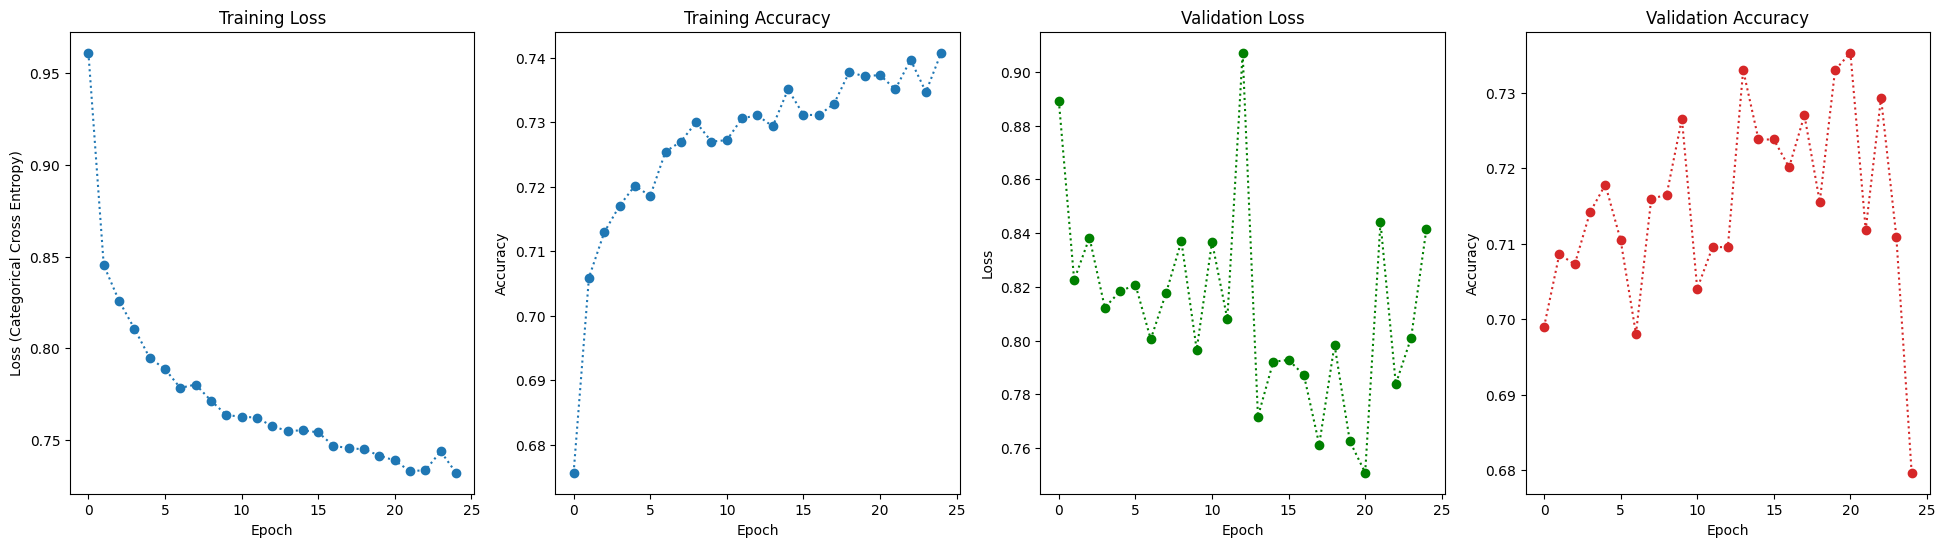

In [33]:
import itertools
import random

# Define the grid
param_grid = {
    'EMB_DIM': [64, 128],
    'FF_DIM': [128, 256],
    'NUM_HEADS': [2, 4],
    'NUM_BLOCKS': [1, 2],
    'DROPOUT': [0.1, 0.3],
    'LAYER_EPS': [1e-5],
    'LR': [1e-4, 5e-5],
}

# Get all combinations
param_combos = list(itertools.product(*param_grid.values()))
random.shuffle(param_combos)  # Randomize for random search

best_val_loss = 0.0
best_params = None
best_model = None

for i, combo in enumerate(param_combos):
    params = dict(zip(param_grid.keys(), combo))
    print(f"\n🔍 Trying config {i+1}/{len(param_combos)}: {params}")
    
    # Instantiate model
    model = TransformerClassifier(
        input_dim=input_dim,
        embed_dim=params['EMB_DIM'],
        ff_dim=params['FF_DIM'],
        num_heads=params['NUM_HEADS'],
        num_blocks=params['NUM_BLOCKS'],
        num_classes=num_classes,
        dropout=params['DROPOUT'],
        norm_eps=params['LAYER_EPS'],
        device=device
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=params['LR'])
    scheduler = CosineWarmupScheduler(optimizer, warmup=WARM_UP, max_iters=MAX_ITER)
    criterion = torch.nn.CrossEntropyLoss()

    model, val_loss = training(model)
    
    # Track best model
    if val_loss > best_val_loss:
        best_val_loss = val_loss
        best_params = params
        best_model = model.state_dict()

print("\n✅ Best config:", best_params)
print(f"Validation Loss: {best_val_loss:.4f}")


Epoch [18/100], Batch [100/545], Loss: 0.6132
Epoch [18/100], Batch [200/545], Loss: 1.1735
Epoch [18/100], Batch [300/545], Loss: 0.5327
Epoch [18/100], Batch [400/545], Loss: 0.5156
Epoch [18/100], Batch [500/545], Loss: 0.8007
Epoch [18/100] Loss: 0.6480, Accuracy: 0.7648
Validation Loss: 0.7769, Validation Accuracy: 0.7068
No improvement in validation loss for 5 epoch(s).
Early stopping triggered after 5 epochs without improvement.
Loaded best model based on validation loss.
Test Loss: 0.7488, Test Accuracy: 0.7506


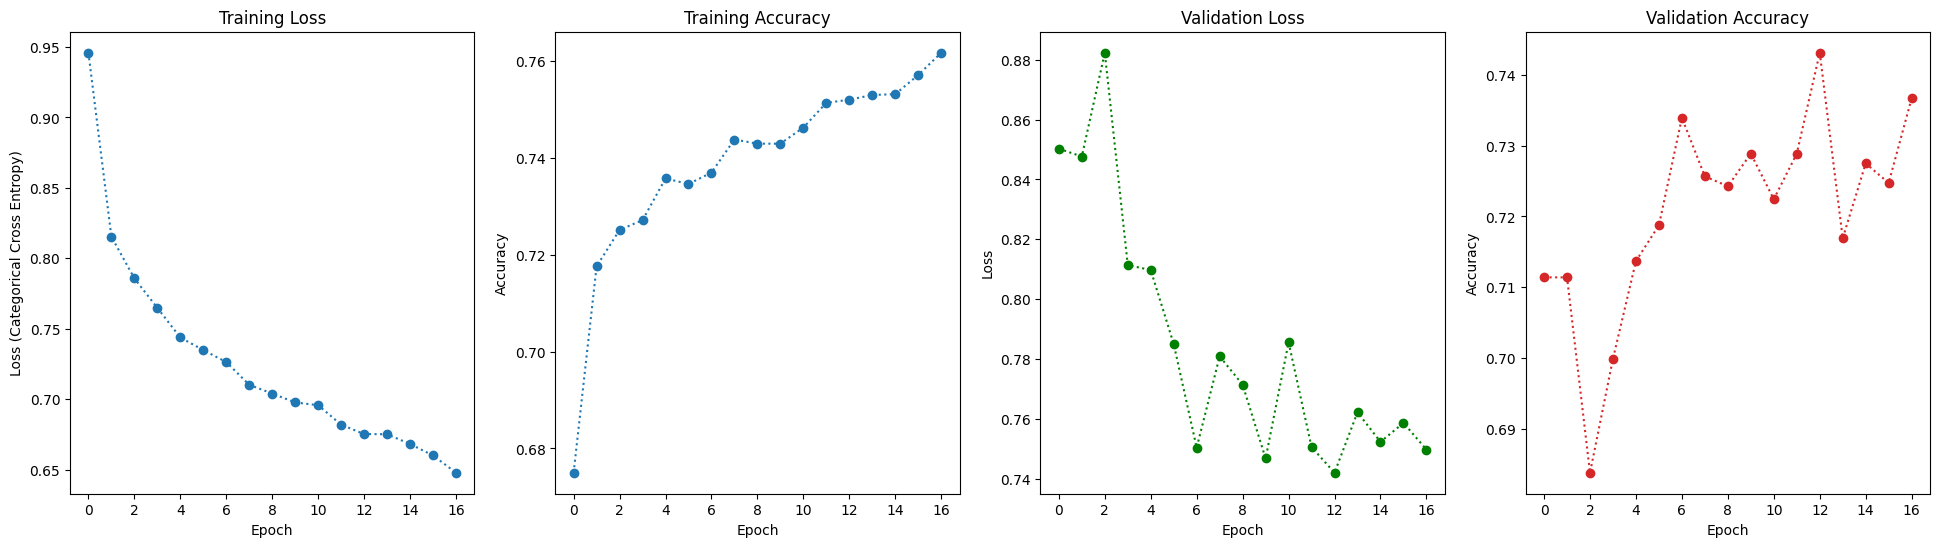

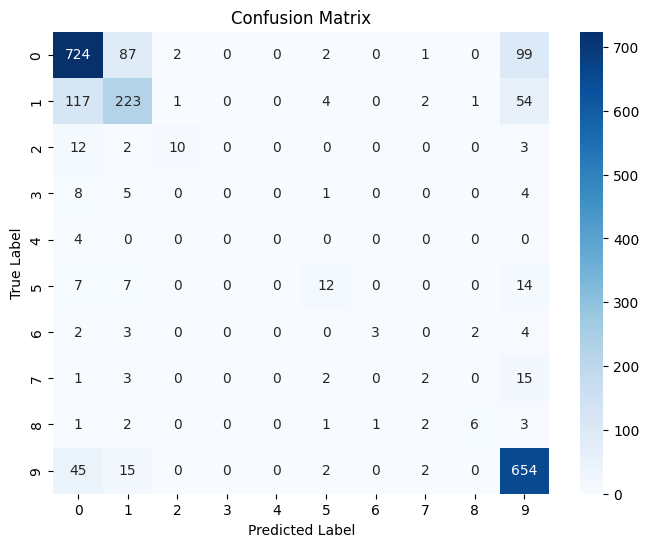

Evaluation Metrics:
              precision    recall  f1-score   support

           0     0.7861    0.7913    0.7887       915
           1     0.6427    0.5547    0.5955       402
           2     0.7692    0.3704    0.5000        27
           3     0.0000    0.0000    0.0000        18
           4     0.0000    0.0000    0.0000         4
           5     0.5000    0.3000    0.3750        40
           6     0.7500    0.2143    0.3333        14
           7     0.2222    0.0870    0.1250        23
           8     0.6667    0.3750    0.4800        16
          10     0.7694    0.9109    0.8342       718

    accuracy                         0.7506      2177
   macro avg     0.5106    0.3603    0.4032      2177
weighted avg     0.7336    0.7506    0.7366      2177



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
from sklearn.metrics import classification_report


# Data preparation
input_dim = X_train.shape[1]  # Number of features (columns)
num_classes = len(set(y_train))  # Number of unique classes

# Instantiate the model
model = TransformerClassifier(
    input_dim=input_dim,     # Number of features
    embed_dim=64,       # Embedding dimension
    ff_dim=128,           # Feedforward layer dimension
    num_heads=4,     # Number of attention heads
    num_blocks=2,   # Number of transformer blocks
    num_classes=num_classes, # Number of classes
    dropout=0.1,         # Dropout rate
    norm_eps=1e-05,      # Layer norm epsilon for numerical stability
    device=torch.device(device)
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model, val_loss = training(model)

model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

all_preds = []
all_labels = []

with torch.no_grad():  
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        outputs = model(X_test_batch)
        
        loss = criterion(outputs, y_test_batch)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())  # Store predictions on CPU
        all_labels.extend(y_test_batch.cpu().numpy())  # Store true labels on CPU
        
        test_correct += (predicted == y_test_batch).sum().item()
        test_total += y_test_batch.size(0)

# Calculate average test loss and accuracy
test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report, confusion_matrix

# Calculate classification report
report = classification_report(all_labels, all_preds, digits=4)

# Print evaluation metrics
print("Evaluation Metrics:")
print(report)